In [6]:
# Import everything we will need
import spectrapepper
from pathlib import Path
import numpy as np
from astropy.io import fits
from matplotlib.pyplot import figure, show, close
import matplotlib as mpl
from astropy.visualization import ImageNormalize, SquaredStretch
import scipy.signal as ss
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

In [7]:
# Define where the directory is located
datadir2 = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope/Live"
datadir = "C:/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope"
procdir = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope/Process/i"

# Use pathlib.Path to create a pathobject
pathobject = Path(datadir)
pathobject2 = Path(datadir2)

myfitsfiles = []
myfitsfiles2 = []

# Loop over all files in the directory and grab the fits files
for f in pathobject.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles.append(f)

for f in pathobject2.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles2.append(f)

# Print first 10 fitsfiles to check if we got everything correct        
for i in range(10):
    print(myfitsfiles[i])

C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000001.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000002.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000003.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000004.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000005.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000006.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000007.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000008.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000009.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000010.BIAS.FIT


In [8]:
# Create the image class

class image:
    def __init__(self, filepath, fits_imagetyp='', fits_exptime=0, fits_filter='', fits_date_obs=0, fits_naxis1=0, fits_naxis2=0, pixelsize=18):
        self.filepath = filepath
        self.filename = filepath.name
        self.imagetyp = fits_imagetyp
        self.exptime = fits_exptime
        self.filter = fits_filter
        self.date_obs = fits_date_obs
        self.naxis1 = fits_naxis1
        self.naxis2 = fits_naxis2
        self.pixelsize = pixelsize

myimages = []
myimages2 = []

# Loop over all of the filepaths in myfitsfiles, open each image, give it the image class and append it to the list of images
for filepath in myfitsfiles:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ'))
    myimages.append(newimage)
    hdulist.close()

for filepath in myfitsfiles2:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ'))
    myimages2.append(newimage)
    hdulist.close()

# Comment for self: Dark Frame, Bias Frame, Flat Field, Light Frame

In [9]:
# Create the masterbias
# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Bias_list = []
count = 0
for im in myimages2:
    if 'bias frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Bias_list.append(dat)
        hdulist.close

# Then we median combine the images        
Bias_stack = np.stack(Bias_list)
masterbias = np.median(Bias_stack, axis=0)

del Bias_list, Bias_stack

In [10]:
# Create the masterdark
# Loop over all the images in our list and check if they are Dark frames, if they are append them to the list
# We didn't have time to shoot our own darks, so we used older ones

Darks_list = []
count = 0
for im in myimages:
    if 'dark frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Darks_list.append((dat - masterbias)/im.exptime)
        hdulist.close

# Then we median combine the darks
Darks_stack = np.stack(Darks_list)
masterdark = np.median(Darks_stack, axis=0)

del Darks_list, Darks_stack

In [16]:
# Let's do the masterflat next

# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Flats_list = []
count = 0
for im in myimages2:
    if 'flat field' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Flats_list.append(dat)
        hdulist.close
# 
# # Lets inspect the Flats
# c = 0
# for obj in Flats_list:
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     norm = ImageNormalize(stretch=SquaredStretch())
#     frame.imshow(obj, interpolation='none', origin='lower', cmap='gray', norm=norm)
#     frame.set_title(f"{c}, min = {np.min(obj)}, max = {np.max(obj)}")
#     show(fig)
#     close(fig)
#     c += 1

# We see that the first 5 show a proper flat
Flats_list_sorted = Flats_list[0:4]

# Then we calibrate the flats with masterbias and median combine the images (We don't need to concern with the darks as the dark current can't really build up during flats)
Flats_stack = np.stack(Flats_list_sorted - masterbias)
masterflat = np.median(Flats_stack, axis=0)

del Flats_list,Flats_list_sorted, Flats_stack


# Flats_stack_normalized = Flats_stack / Flats_median
# masterflat_to_be_normalized = np.median(Flats_stack_normalized, axis=0)
# masterflat = masterflat_to_be_normalized / np.median(masterflat_to_be_normalized)

In [12]:
# Now that we have our master calibration files we can work on our lights, first we calibrate using darks and bias
# Flat calibration will be done later in the processing, because the dark areas between the fibres mess up the median
lights = []
for im in myimages2:
    if 'light frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        data = hdulist[0].data.astype(float)
        data -= masterdark*im.exptime + masterbias
        lights.append(data)
        hdulist.close

# Let's inspect the lights
# c = 0
# for obj in lights:
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.imshow(obj, interpolation='none', origin='lower', cmap='gray')
#     frame.set_title(f"light {c} with min: {obj.min()}, max: {obj.max()}")
#     show(fig)
#     close(fig)
#     c += 1

In [13]:
def median_combine(lights_sorted):
    '''
    :param: lights_sorted: list of light frames
    :return: median of light frames 
    '''
    return np.median(np.stack(lights_sorted), axis=0)


# Based on the logsheet and printing all images we determine the following sorting of the targets
lights_sorted_galaxy = lights[32:34]+lights[36:42]
lights_sorted_vega = lights[43:48]
lights_sorted_moon = lights[-5:-1]
lights_calibration = lights[21:25]
lights_sorted_arcturus = lights[29:31]
lights_sorted_regulus = lights[26:27]

del lights

master_galaxy = median_combine(lights_sorted_galaxy)
master_vega = median_combine(lights_sorted_vega)
master_moon = median_combine(lights_sorted_moon)
master_calibration = median_combine(lights_calibration)
master_arcturus = median_combine(lights_sorted_arcturus)
master_regulus = median_combine(lights_sorted_regulus)

In [24]:
# We need to know where the spectral lines are. This is easiest done by using the flat frames first slice in a vertical line
vert_slice = masterflat[:,1000]

# Based on the plot we want to exclude values with less then 10000 counts
fibre_locations = np.where(vert_slice>1000)[0]

# Now we would like to group all of the values in a single fibre into a single median value to reduce noise, although we do clearly see that the values on the outside are significantly less then the ones in the center.
fibre_locations_dict = {}
i = 1
n = "fibre_0"
c = 0

for obj in fibre_locations:
    try:
        if obj+1 == fibre_locations[i]:
            try:
                fibre_locations_dict[n].append(obj)
            except:
                fibre_locations_dict[n] = []
                fibre_locations_dict[n].append(obj)
        else:
            fibre_locations_dict[n].append(obj)
            c+=1
            n = f'fibre_{c}'
        i+=1

    except:
        fibre_locations_dict[n].append(obj)
        
# print(fibre_locations_dict)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(vert_slice)
# # frame.axis([600, 700, 8, 10])
# frame.set_title('Veritcal slice at x = 1000')
# frame.set_xlabel('Pixel from top to bottom')
# frame.set_ylabel('Intensity [counts]')
# frame.grid(alpha = 0.5)
# fig.savefig('Flatfield.png', dpi=300)
# show(fig) 
# close(fig)

In [25]:
# Now that we have the locations of the fibres we make an intensity plot of the median of all the collumns that a fibre consists of.
def find_maximum_slice(horizontal_slice_dict):
    '''
    :purpose: Finds the location of the slice which contains the maximum value
    :input: Dictionary medians of horizontal slices
    :return: The location of the slice which contains the maximum value
    '''
    Total_max = np.max(horizontal_slice_dict['fibre_0'])
    for i in horizontal_slice_dict:
        Max_of_row = np.max(horizontal_slice_dict[i])
        if Max_of_row>Total_max:
            Total_max = Max_of_row
            location = i
    return location

def average_fibre(fibre_locations_dict,master,flat_slice_dict={}):
    '''
    :purpose: Calculates the weighted average of each fibre
    :param: fibre_locations_dict, master
    :return: Dictionary of numbered fibres
    '''
    if len(flat_slice_dict)==0:
        flat_slice_dict = {}
        flat_slice_average_dict = {}
        for i in fibre_locations_dict:
            flat_slice = master[fibre_locations_dict[i],:]
            flat_slice_dict[i] = flat_slice
            flat_slice_average_dict[i] = np.average(flat_slice, axis=0, weights=flat_slice)
        return flat_slice_dict,flat_slice_average_dict
    else:
        horizontal_slice_dict_average = {}
        for i in fibre_locations_dict:
            horizontal_slice = master[fibre_locations_dict[i],:]
            horizontal_slice_dict_average[i] = np.average(horizontal_slice, axis=0, weights = flat_slice_dict[i])
        return horizontal_slice_dict_average

# Calculate the weighted average of each of the fibres     
flat_slice_dict, flat_slice_average_dict = average_fibre(fibre_locations_dict,masterflat)
horizontal_slice_galaxy_dict = average_fibre(fibre_locations_dict,master_galaxy,flat_slice_dict)
horizontal_slice_vega_dict = average_fibre(fibre_locations_dict,master_vega,flat_slice_dict)
horizontal_slice_moon_dict = average_fibre(fibre_locations_dict,master_moon,flat_slice_dict)
horizontal_slice_calibration_dict = average_fibre(fibre_locations_dict,master_calibration,flat_slice_dict)
horizontal_slice_arcturus_dict = average_fibre(fibre_locations_dict,master_arcturus,flat_slice_dict)
horizontal_slice_regulus_dict = average_fibre(fibre_locations_dict,master_regulus,flat_slice_dict)

# We want to save the horizontal_slice_dict and use it in further stuff
location_of_maximum_galaxy_dict = find_maximum_slice(horizontal_slice_galaxy_dict)
location_of_maximum_vega = find_maximum_slice(horizontal_slice_vega_dict)
location_of_maximum_moon = find_maximum_slice(horizontal_slice_moon_dict)
location_of_maximum_calibration = find_maximum_slice(horizontal_slice_calibration_dict)
location_of_maximum_arcturus = find_maximum_slice(horizontal_slice_arcturus_dict)
location_of_maximum_regulus = find_maximum_slice(horizontal_slice_regulus_dict)

In [27]:
# Shift calculation based on the biggest spike in the calibration data!
def calculate_shifts(calibration_dict):
    ''''
    :purpose: Calculates the relative shift between the fibres using the calibration data
    :param calibration_dict: Dictionary of numbered fibres of calibration data
    :return shifts: Dictionary of shifts as to allign all fibres 
    '''
    Maximums = {}
    Maximums_list = []
    shifts = {}

    for i in calibration_dict.keys():
        Maximum = np.where(calibration_dict[i]==np.max(calibration_dict[i]))[0][0]
        Maximums[i] = Maximum
        Maximums_list.append(Maximum)
    centre = np.median(Maximums_list)

    for i in calibration_dict.keys():
        shifts[i] = centre - Maximums[i]
    return(shifts)

shifts = calculate_shifts(horizontal_slice_calibration_dict)

In [30]:
def align_spectra(average_dict, shifts):
    '''
    :purpose: Aligns and crops all the fibres such that there is no longer a relative horizontal shift between the fibres
    :param average_dict: Dictionary of light frames
    :param shifts: Dictionary of relative shifts
    :return cropped: Dictionary of aligned fibres
    '''
    # First align the fibres
    aligned_average_dict = {}
    for i in average_dict.keys():
        if shifts[i] > 0:
            shift = int(shifts[i])
            aligned_average_dict[i] = average_dict[i][shift::]
            aligned_average_dict[i] = np.insert(aligned_average_dict[i],0,np.zeros(shift))
        if shifts[i] < 0:
            shift = int(abs(shifts[i]))
            aligned_average_dict[i] = average_dict[i][:-shift:]
            aligned_average_dict[i] = np.insert(aligned_average_dict[i],-1,np.zeros(shift))
        else:
            aligned_average_dict[i] = average_dict[i]

    # After alligning we can crop
    maximum_shift = 0
    minimum_shift = 0
    cropped = {}
    for i in shifts:
        if shifts[i] > maximum_shift:
            maximum_shift = shifts[i]
        elif shifts[i] < minimum_shift:
            minimum_shift = shifts[i]

    minimum_shift = int(abs(minimum_shift))
    maximum_shift = int(abs(maximum_shift))

    for i in aligned_average_dict.keys():
        cropped[i] = aligned_average_dict[i][maximum_shift:-minimum_shift:]

    return cropped

def background_subtraction(aligned_average_dict):
    '''
    :purpose: subtract the background to see fainter emmision and absorption lines
    :param aligned_average_dict: Dictionary of light frames
    :return background_subtracted: Dictionary of background subtracted fibres
    '''
    aligned_average_list = []
    for i in aligned_average_dict.keys():
        aligned_average_list.append(aligned_average_dict[i])
    aligned_stack = np.stack(aligned_average_list)
    background = np.median(aligned_stack, axis=0)

    background_subtracted = {}
    for i in aligned_average_dict.keys():
        background_subtracted[i] = aligned_average_dict[i] / background
    return background_subtracted

# fix the relative shift between the fibres
cropped_flat = align_spectra(flat_slice_average_dict, shifts)
cropped_galaxy = align_spectra(horizontal_slice_galaxy_dict, shifts)
cropped_vega = align_spectra(horizontal_slice_vega_dict, shifts)
cropped_moon = align_spectra(horizontal_slice_moon_dict, shifts)
cropped_calibration = align_spectra(horizontal_slice_calibration_dict, shifts)
cropped_arcturus = align_spectra(horizontal_slice_arcturus_dict, shifts)
cropped_regulus = align_spectra(horizontal_slice_regulus_dict, shifts)

# Background subtract the galaxy data
galaxy_background_subtracted = background_subtraction(cropped_galaxy)

# for fibre in galaxy_background_subtracted.keys():
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.plot(cropped_flat[fibre])
#     # frame.plot(wavelength_calibrated, aligned_average_dict[fibre]/aligned_average_dict[fibre].max())
#     frame.set_title(f"Background subtracted {fibre}")
#     frame.grid() 
#     show(fig)
#     close(fig)

[ 502  567 1041 1058 1309 1597 1613 1836 1843 1908 1910 1944]


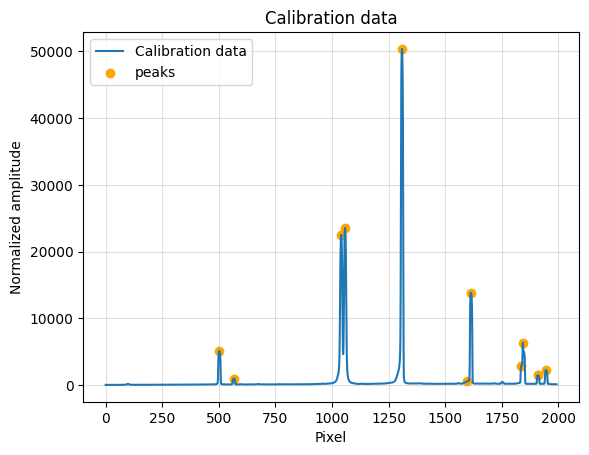

In [31]:
# get the actual peaks
peaks, _ = find_peaks(cropped_calibration[location_of_maximum_calibration], height=500)

print(peaks)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(cropped_calibration[location_of_maximum_calibration], label = 'Calibration data')
frame.scatter(peaks, cropped_calibration[location_of_maximum_calibration][peaks],color='orange', label = 'peaks', marker = 'o')
frame.set_title(f"Calibration data")
frame.set_ylabel('Normalized amplitude')
frame.set_xlabel('Pixel')
frame.grid(alpha = 0.4)
frame.legend(loc = 'upper left')
fig.savefig('Calibration data')
show(fig)
close(fig)


# # Create visual for presentation
# fibres = ['fibre_5', 'fibre_15', 'fibre_25', 'fibre_35', 'fibre_45', 'fibre_55']
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# for fibre in fibres:
#     frame.plot(calibration_horizontal_dict[fibre]/np.max(calibration_horizontal_dict[fibre]), label = fibre)
# frame.axis([450, 550, 0, 0.15])
# frame.set_title(f"Calibration data shift")
# frame.set_ylabel('Normalized amplitude')
# frame.set_xlabel('Pixel')
# frame.grid(alpha = 0.4)
# frame.legend()
# fig.savefig('Calibration data shift')
# show(fig)
# close(fig)

 
-1.217 x + 7053


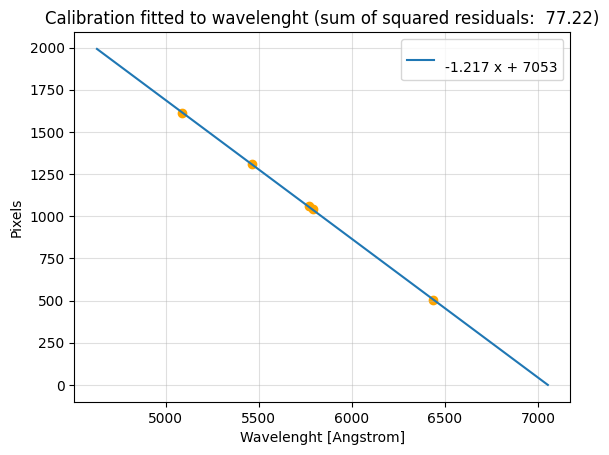

In [32]:
pixels_xaxis = cropped_calibration[location_of_maximum_calibration].shape[0]

# We don't want to use all of the peaks because some cannot be identified
Our_peak_location = peaks[np.array([0,2,3,4,6])]
Calibration_peak_locations = np.array([6438, 5791, 5770, 5461, 5086])

Lenght_our_x_axis = np.arange(0,pixels_xaxis, 1)

def wavelengthfit(a1,c1, degree):
    ''''
    :purpose: Function to calculate the wavelength calibration polynomial
    :param: a1 and c1 are arrays where the first is the pixel values found and c1 are the wavelength values
    :return: wavelength calibration polynomial
    '''
    y = np.polyfit(a1,c1,degree, full=True)
    return(y)

Function = (wavelengthfit(Our_peak_location,Calibration_peak_locations, 1))
y = np.poly1d(Function[0])

print(y)

wavelength_calibrated = np.polyval(y, Lenght_our_x_axis)
# cropped_wavelength = wavelength_calibrated[maximum_shift:-minimum_shift:]

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Lenght_our_x_axis, label = y)
frame.scatter(Calibration_peak_locations, Our_peak_location, color='orange')
# frame.plot(Y, range(Y.size))
frame.set_title(f"Calibration fitted to wavelenght (sum of squared residuals: {Function[1][0]: .4})")
frame.grid(alpha = 0.4)
frame.legend()
frame.set_xlabel('Wavelenght [Angstrom]')
frame.set_ylabel('Pixels')
fig.savefig('Calibration fitted to wavelenght.png', dpi=300)
show(fig)
close(fig)

In [52]:
def peaks_to_wavelength(Array_with_y):
    '''
    :purpose: Function that converts an array of pixels to an array of wavelengths
    :param Array_with_y: Array of x,y coördinate peaks
    :return 1: Array of pixels flipped
    :return 2: Array of wavelengths
    '''
    peaks_pixel = []
    for x,_ in Array_with_y:
        peaks_pixel.append(int(x))
    return np.sort(peaks_pixel)[::-1], np.sort(np.polyval(y,peaks_pixel))


# We should get this from Timo when it is added to notebook
Arcturus_peaks_with_y = np.array([(1793, 1.0), (399, 0.6428682518322371), (133, 0.33515624708759745), (958, 0.1), (1546,0.3)])
Vega_peaks_with_y = np.array([(198, 1.0), (1597, 0.0010763035604415474), (1863, 0.0007290668308719731)])
Regulus_peaks_with_y = np.array([(1797, 1.0), (398, 0.09840773414254268), (132, 0.015318963453609722)])
Moon_peaks_with_y = np.array([(396, 1.0), (954, 0.6383212534573891), (128, 0.5756135064147742), (1546, 0.2567646603528924), (1797, 0.012043490921988769)])

Arcturus_peaks_pixel, Arcturus_peaks = peaks_to_wavelength(Arcturus_peaks_with_y)
Vega_peaks_pixel = np.sort([131,  399, 1798])[::-1]
Vega_peaks = np.sort(np.polyval(y,Vega_peaks_pixel))
Regulus_peaks_pixel = np.sort([131,  399, 1797])[::-1]
Regulus_peaks = np.sort(np.polyval(y,Regulus_peaks_pixel))
Moon_peaks_pixel, Moon_peaks = peaks_to_wavelength(Moon_peaks_with_y)

print(f"Arcturus: ", Arcturus_peaks, Arcturus_peaks_pixel)
print(f"Vega: ", Vega_peaks, Vega_peaks_pixel)
print(f"Regulus: ", Regulus_peaks, Regulus_peaks_pixel)
print(f"Moon: ", Moon_peaks, Moon_peaks_pixel)

Arcturus:  [4871.53781968 5172.09354097 5887.58651312 6567.79156658 6891.46695874] [1793 1546  958  399  133]
Vega:  [4865.45369577 6567.79156658 6893.90060831] [1798  399  131]
Regulus:  [4866.67052055 6567.79156658 6893.90060831] [1797  399  131]
Moon:  [4866.67052055 5172.09354097 5892.45381225 6571.44204093 6897.55108266] [1797 1546  954  396  128]


In [35]:
# Identify the peaks
n_vega = ['Hβ - 4870','Hα - 6567','O2 - 6892']
n_Arcturus = ['Hβ - 4870','Mg I - 5178', 'Na I - 5894', 'Hα - 6567','O2 - 6892']
n_Regulus = ['Hβ - 4870', 'Hα - 6573', 'O2 - 6897']
n_Moon = ['Hβ - 4864', 'Mg I - 5169', 'Na I - 5890', 'Hα - 6569', 'O2 - 6896']

In [37]:
vega_calibration = np.loadtxt('miles_spec_txt_s0592.txt')

wavelength = []
values = []

size = int(vega_calibration.size/2)

for i in range(size):
    wavelength.append(vega_calibration[i][0])
    values.append(vega_calibration[i][1])

# convert both to np arrays
vega_calibration_wavelength = np.array(wavelength)
vega_calibration_values = np.array(values)

# First we get the max and min values of our actual data
minimum_wavelength = wavelength_calibrated[-1]
maximum_wavelength = wavelength_calibrated[0]

# We crop the calibration data to our range
mask1 = vega_calibration_wavelength > minimum_wavelength
vega_calibration_wavelength = vega_calibration_wavelength[mask1]
vega_calibration_values = vega_calibration_values[mask1]

mask2 = vega_calibration_wavelength < maximum_wavelength
vega_calibration_wavelength = vega_calibration_wavelength[mask2]
vega_calibration_values = vega_calibration_values[mask2]

# Then we interpolate the calibration data so it matches ours
# la = len(aligned_average_dict[location_of_maximum])

interpolated_vega_calibration_values = np.interp(wavelength_calibrated, vega_calibration_wavelength, vega_calibration_values)

In [38]:
Vega_flat_calibrated = cropped_vega[location_of_maximum_vega]/(cropped_flat[location_of_maximum_vega]/np.median(cropped_flat[location_of_maximum_vega]))
Regulus_flat_calibrated = cropped_regulus[location_of_maximum_regulus]/(cropped_flat[location_of_maximum_regulus]/np.median(cropped_flat[location_of_maximum_regulus]))
Arcturus_flat_calibrated = cropped_arcturus[location_of_maximum_arcturus]/(cropped_flat[location_of_maximum_arcturus]/np.median(cropped_flat[location_of_maximum_arcturus]))
Moon_flat_calibrated = cropped_moon[location_of_maximum_moon]/(cropped_flat[location_of_maximum_moon]/np.median(cropped_flat[location_of_maximum_moon]))

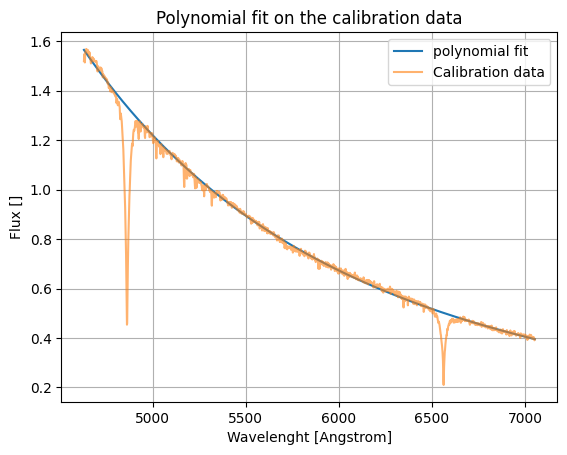

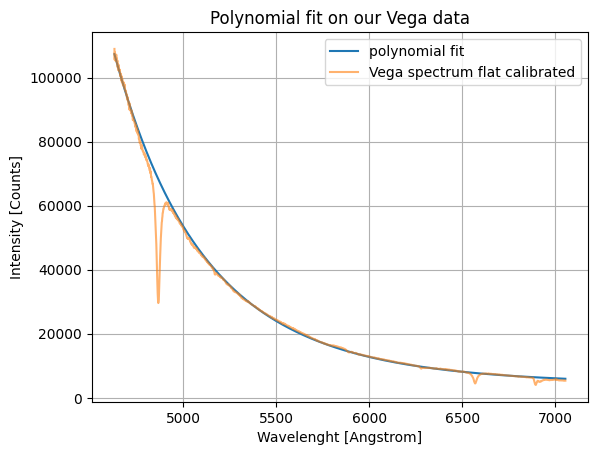

In [39]:
from scipy.optimize import curve_fit
def f(x,n,b,p):
    '''
    :purpose: Returns the value of the function f(x)=b+n/(x**p) function where b,n and p are constants
    :param x: Range of x values
    :param n: Constant
    :param b: Constant
    :param p: Constant
    :return: Value of the Gaussian function
    '''
    return b+n/(x**p)

line1 = np.polyfit((300,500),(interpolated_vega_calibration_values[300],interpolated_vega_calibration_values[500]),deg=1)
m1 = np.polyval(line1,range(300,500))

line2 = np.polyfit((1700,1900),(interpolated_vega_calibration_values[1700],interpolated_vega_calibration_values[1900]),deg=1)
m2 = np.polyval(line2,range(1700,1900))

line1_ourdata = np.polyfit((300,500),(Vega_flat_calibrated[300],Vega_flat_calibrated[500]),deg=1)
m1_ourdata = np.polyval(line1_ourdata,range(300,500))

line2_ourdata = np.polyfit((1700,1900),(Vega_flat_calibrated[1700],Vega_flat_calibrated[1900]),deg=1)
m2_ourdata = np.polyval(line2_ourdata,range(1700,1900))

no_peak_part1 = list(interpolated_vega_calibration_values[0:300])
no_peak_part2 = list(m1)
no_peak_part3 = list(interpolated_vega_calibration_values[500:1700])
no_peak_part4 = list(m2)
no_peak_part5 = list(interpolated_vega_calibration_values[1900:])

no_peak = no_peak_part1 + no_peak_part2 + no_peak_part3 + no_peak_part4 + no_peak_part5
no_peak = np.array(no_peak)

no_peak_ourdata_part1 = list(Vega_flat_calibrated[0:300])
no_peak_ourdata_part2 = list(m1_ourdata)
no_peak_ourdata_part3 = list(Vega_flat_calibrated[500:1700])
no_peak_ourdata_part4 = list(m2_ourdata)
no_peak_ourdata_part5 = list(Vega_flat_calibrated[1900:])

no_peak_ourdata = no_peak_ourdata_part1 + no_peak_ourdata_part2 + no_peak_ourdata_part3 + no_peak_ourdata_part4 + no_peak_ourdata_part5
no_peak_ourdata = np.array(no_peak_ourdata)

beta, pcov = curve_fit(f,wavelength_calibrated,no_peak, p0=(1*10**11,-1.5,1.27),bounds=((1*10**10.,-4.,0.),(1*10**12.,0.,10.)))
vega_calibration_fit = f(wavelength_calibrated, *beta)

beta_ourdata, pcov_ourdata = curve_fit(f,wavelength_calibrated,no_peak_ourdata, p0=( 1*10**39.7,10**3.7,9.5),bounds=((1*10**17.,10**2.,0.),(1*10**78.,10**5.,20.)))
Ourdata_fit = f(wavelength_calibrated, *beta_ourdata)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated,vega_calibration_fit, label = 'polynomial fit')
frame.plot(wavelength_calibrated, interpolated_vega_calibration_values, alpha = 0.6, label = 'Calibration data')
frame.set_title(f"Polynomial fit on the calibration data")
frame.grid()
frame.legend()
frame.set_xlabel('Wavelenght [Angstrom]')
frame.set_ylabel('Flux []')
fig.savefig('Calibrationd data fit.png', dpi = 300)
show(fig)
close(fig)


fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated,Ourdata_fit, label = 'polynomial fit')
frame.plot(wavelength_calibrated, Vega_flat_calibrated, alpha = 0.6, label = 'Vega spectrum flat calibrated')
frame.set_title(f"Polynomial fit on our Vega data")
frame.grid()
frame.legend()
frame.set_xlabel('Wavelenght [Angstrom]')
frame.set_ylabel('Intensity [Counts]')
fig.savefig('Our data fit.png', dpi = 300)
show(fig)
close(fig)

In [40]:
# Now we can calculate the response curve and calibrate our data
response = Ourdata_fit/vega_calibration_fit

# Let's apply this response curve to our data sets
Vega_response_corrected = Vega_flat_calibrated/response
Arcturus_response_corrected = Arcturus_flat_calibrated/response
Regulus_response_corrected = Regulus_flat_calibrated/response
Moon_response_corrected = Moon_flat_calibrated/response

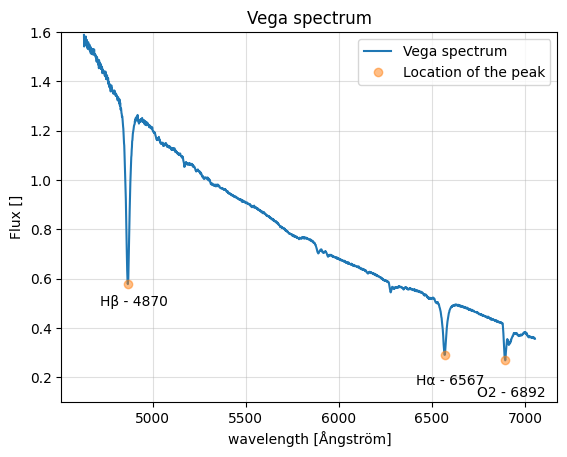

In [41]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Vega_response_corrected, label = 'Vega spectrum')
frame.plot(Vega_peaks,Vega_response_corrected[Vega_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_vega):
    frame.annotate(txt, (Vega_peaks[i], Vega_response_corrected[Vega_peaks_pixel][i]), (Vega_peaks[i]-150-i, Vega_response_corrected[Vega_peaks_pixel][i]-0.09-i*0.03))
frame.set_title(f"Vega spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
frame.set_ylim([0.1,1.6])
# fig.savefig('Vega response calibrated.png', dpi=300)
show(fig)
close(fig)

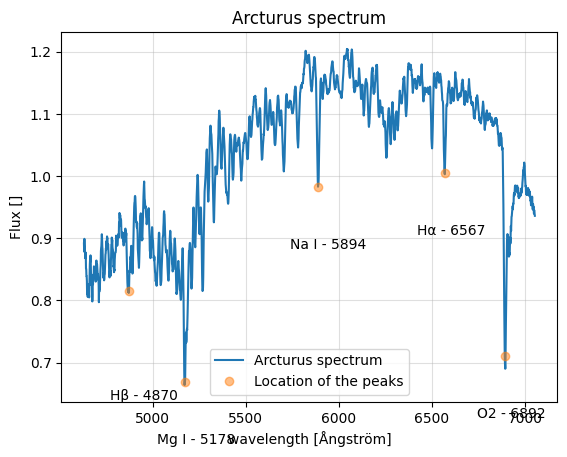

In [42]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Arcturus_response_corrected, label = 'Arcturus spectrum')
frame.plot(Arcturus_peaks,Arcturus_response_corrected[Arcturus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peaks')
for i, txt in enumerate(n_Arcturus[1::],1):
    frame.annotate(txt, (Arcturus_peaks[i], Arcturus_response_corrected[Arcturus_peaks_pixel][i]), (Arcturus_peaks[i]-150, Arcturus_response_corrected[Arcturus_peaks_pixel][i]-0.1))
frame.annotate(n_Arcturus[0], (Arcturus_peaks[0], Arcturus_response_corrected[Arcturus_peaks_pixel][0]), (Arcturus_peaks[0]-100, Arcturus_response_corrected[Arcturus_peaks_pixel][0]-0.175))
frame.set_title(f"Arcturus spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend(loc = 'lower center')
frame.grid(alpha = 0.4)
# fig.savefig('Arcturus response calibrated.png', dpi=300)
show(fig)
close(fig)

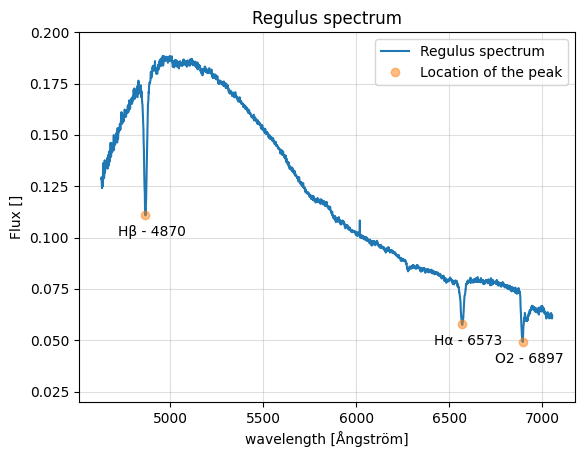

In [43]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Regulus_response_corrected, label = 'Regulus spectrum')
frame.plot(Regulus_peaks,Regulus_response_corrected[Regulus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Regulus):
    frame.annotate(txt, (Regulus_peaks[i], Regulus_response_corrected[Moon_peaks_pixel][i]), (Regulus_peaks[i]-150, Regulus_response_corrected[Regulus_peaks_pixel][i]-0.01))
frame.set_title(f"Regulus spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
frame.set_ylim([0.02,0.2])
# fig.savefig('Regulus response calibrated.png', dpi=300)
show(fig)
close(fig)

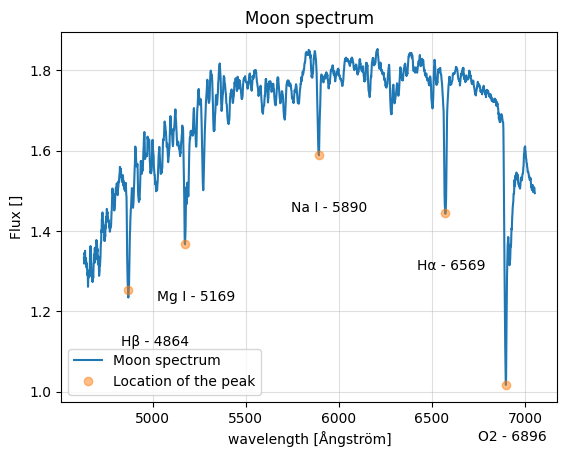

In [44]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Moon_response_corrected, label = 'Moon spectrum')
frame.plot(Moon_peaks,Moon_response_corrected[Moon_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Moon):
    if i == 0:
        frame.annotate(txt, (Moon_peaks[i], Moon_response_corrected[Moon_peaks_pixel][i]), (Moon_peaks[i]-40, Moon_response_corrected[Moon_peaks_pixel][i]-0.14))
    else:
        frame.annotate(txt, (Moon_peaks[i], Moon_response_corrected[Moon_peaks_pixel][i]), (Moon_peaks[i]-150, Moon_response_corrected[Moon_peaks_pixel][i]-0.14))
frame.set_title(f"Moon spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
# fig.savefig('Moon response calibrated.png', dpi=300)
show(fig)
close(fig)

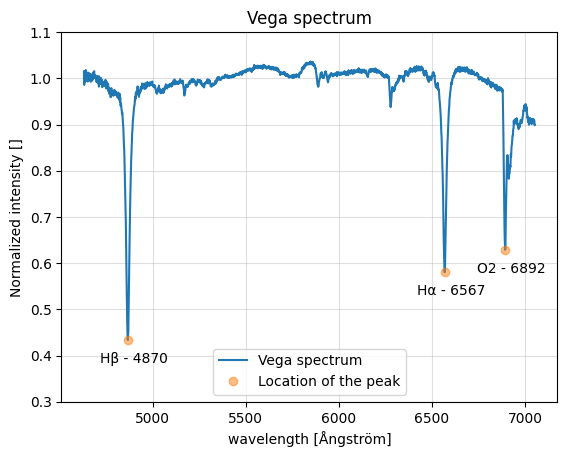

In [45]:
Flatlined_vega = Vega_response_corrected/vega_calibration_fit

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatlined_vega, label = 'Vega spectrum')
frame.plot(Vega_peaks,Flatlined_vega[Vega_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_vega):
    frame.annotate(txt, (Vega_peaks[i], Flatlined_vega[Vega_peaks_pixel][i]), (Vega_peaks[i]-150, Flatlined_vega[Vega_peaks_pixel][i]-0.05))
frame.set_title(f"Vega spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend(loc = 'lower center')
frame.grid(alpha = 0.4)
frame.set_ylim([0.3,1.1])
# fig.savefig('Vega flatline.png', dpi=300)
show(fig)
close(fig)

[7053.30465483 7052.08783004 7050.87100526 ... 4631.82333751 4630.60651273
 4629.38968795]


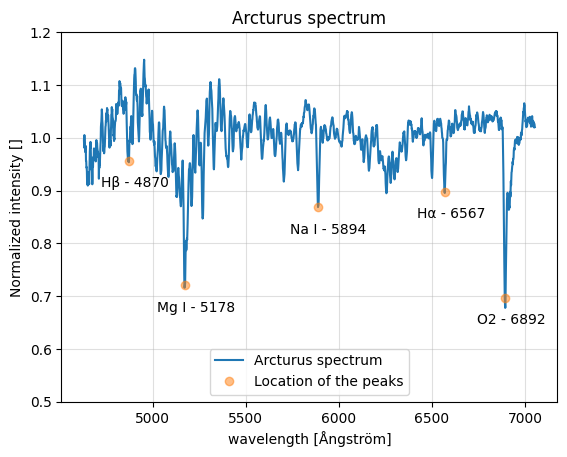

In [46]:
Arcturus_fit_function = np.polyfit(wavelength_calibrated, Arcturus_response_corrected, deg=5)
Arcturus_fit = np.polyval(Arcturus_fit_function, wavelength_calibrated)

Flatline_Arcturus = Arcturus_response_corrected/Arcturus_fit

print(wavelength_calibrated)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatline_Arcturus, label = 'Arcturus spectrum')
frame.plot(Arcturus_peaks,Flatline_Arcturus[Arcturus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peaks')
for i, txt in enumerate(n_Arcturus):
    frame.annotate(txt, (Arcturus_peaks[i], Flatline_Arcturus[Arcturus_peaks_pixel][i]), (Arcturus_peaks[i]-150, Flatline_Arcturus[Arcturus_peaks_pixel][i]-0.05))
frame.set_title(f"Arcturus spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend(loc = 'lower center')
frame.grid(alpha = 0.4)
frame.set_ylim([0.5,1.2])
# fig.savefig('Arcturus flatline.png', dpi=300)
show(fig)
close(fig)

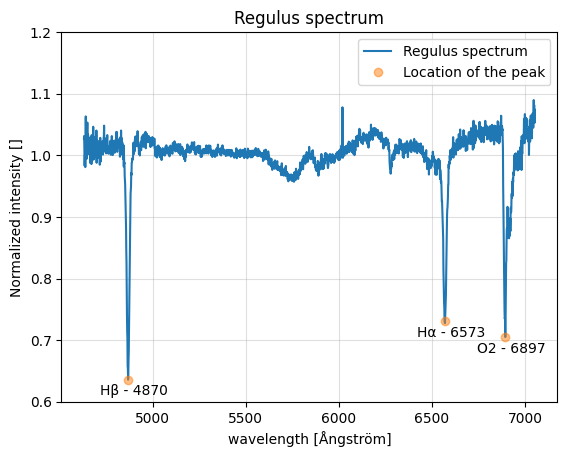

In [47]:
Regulus_fit_function = np.polyfit(wavelength_calibrated, Regulus_response_corrected, deg=5)
Regulus_fit = np.polyval(Regulus_fit_function, wavelength_calibrated)

Flatline_Regulus = Regulus_response_corrected / Regulus_fit

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatline_Regulus, label = 'Regulus spectrum')
frame.plot(Regulus_peaks,Flatline_Regulus[Regulus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Regulus):
    frame.annotate(txt, (Regulus_peaks[i], Flatline_Regulus[Moon_peaks_pixel][i]), (Regulus_peaks[i]-150, Flatline_Regulus[Regulus_peaks_pixel][i]-0.025))
frame.set_title(f"Regulus spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
# fig.savefig('Regulus flatline.png', dpi=300)
frame.set_ylim([0.6,1.2])
show(fig)
close(fig)

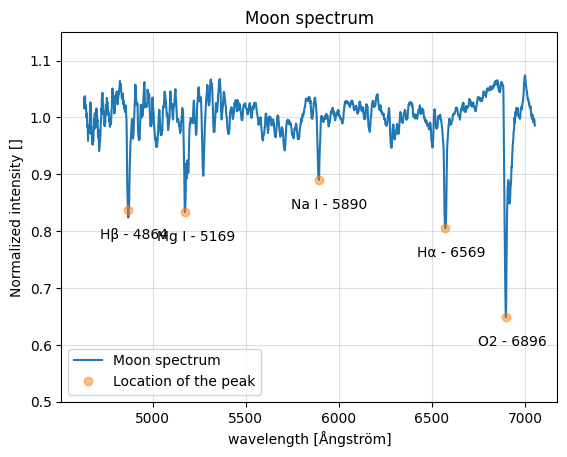

In [48]:
Moon_fit_function = np.polyfit(wavelength_calibrated, Moon_response_corrected, deg=8)
Moon_fit = np.abs(np.polyval(Moon_fit_function, wavelength_calibrated))

Flatline_Moon = (Moon_response_corrected / Moon_fit)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatline_Moon, label = 'Moon spectrum')
frame.plot(Moon_peaks,Flatline_Moon[Moon_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Moon):
    frame.annotate(txt, (Moon_peaks[i], Flatline_Moon[Moon_peaks_pixel][i]), (Moon_peaks[i]-150, Flatline_Moon[Moon_peaks_pixel][i]-0.05))
frame.set_title(f"Moon spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
frame.set_ylim([0.5,1.15])
# fig.savefig('Moon flatline.png', dpi=300)
show(fig)
close(fig)

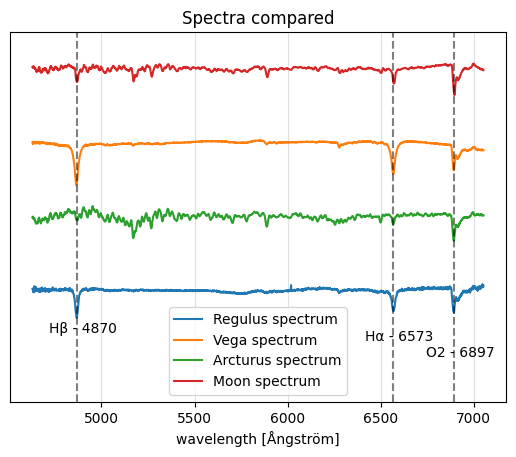

In [49]:
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.plot(wavelength_calibrated, Flatline_Regulus, label='Regulus spectrum')
frame.plot(wavelength_calibrated, Flatlined_vega+2, label = 'Vega spectrum')
frame.plot(wavelength_calibrated, Flatline_Arcturus+1, label = 'Arcturus spectrum')
frame.plot(wavelength_calibrated, Flatline_Moon+3, label = 'Moon spectrum')
for i in Regulus_peaks:
    frame.axvline(i, color='k', linestyle='--', alpha=0.5)
for i, txt in enumerate(n_Regulus):
    frame.annotate(txt, (Regulus_peaks[i], Flatline_Regulus[Moon_peaks_pixel][i]),
                   (Regulus_peaks[i] - 150, Flatline_Regulus[Regulus_peaks_pixel][i] - i*0.2-0.2))
frame.set_title(f"Spectra compared")
frame.set_xlabel('wavelength [Ångström]')
frame.set_yticks([])
frame.legend(loc = 'lower center')
frame.grid(alpha=0.4)
frame.set_ylim([-0.5,4.5])
# fig.savefig('Spectra compared.png', dpi=300)
show(fig)
close(fig)

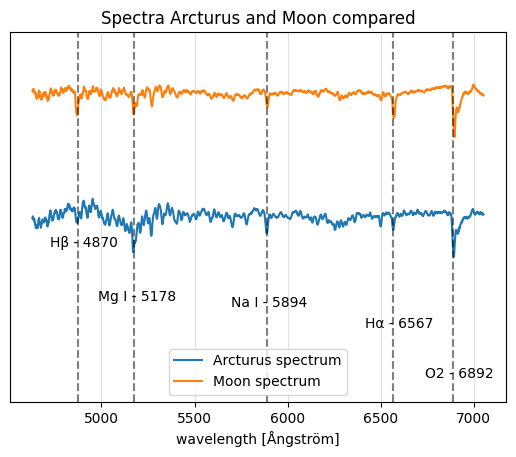

In [50]:
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.plot(wavelength_calibrated, Flatline_Arcturus, label = 'Arcturus spectrum')
frame.plot(wavelength_calibrated, Flatline_Moon+1, label = 'Moon spectrum')
for i in Arcturus_peaks:
    frame.axvline(i, color='k', linestyle='--', alpha=0.5)
for i, txt in enumerate(n_Arcturus):
    if i == 0 or i == 3 or i == 4:
        frame.annotate(txt, (Arcturus_peaks[i], Flatline_Arcturus[Moon_peaks_pixel][i]),(Arcturus_peaks[i]-150, Flatline_Arcturus[Arcturus_peaks_pixel][i] - i*0.2-0.2))
    else:
        frame.annotate(txt, (Arcturus_peaks[i], Flatline_Arcturus[Moon_peaks_pixel][i]),(Arcturus_peaks[i]-190, Flatline_Arcturus[Arcturus_peaks_pixel][i] - i*0.2-0.2))
frame.set_title(f"Spectra Arcturus and Moon compared")
frame.set_xlabel('wavelength [Ångström]')
frame.set_yticks([])
frame.legend(loc = 'lower center')
frame.grid(alpha=0.4)
frame.set_ylim([-0.5,2.5])
fig.savefig('Spectra compared Arctrurus and Moon.png', dpi=300)
show(fig)
close(fig)